Code to test whether strategy-linked brain activity patterns replicate across task conditions.

In [3]:
import warnings, os, sys, glob, matplotlib, scipy
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
matplotlib.rcParams['pdf.fonttype'] = 42 #To make text readable by Illustrator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, collapse_mask
from nltools.stats import threshold, one_sample_permutation, two_sample_permutation, correlation_permutation
from nilearn.plotting import plot_roi
base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection/'

## Load behavioral clusters

In [4]:

fittedParams = pd.read_csv(os.path.join(base_dir,
            'Results/2.Behavior-ClusterModel/ParticipantClustering.csv'),index_col=0)
print fittedParams.head()
subNums = np.array(fittedParams['sub'].unique())
print subNums
print len(subNums)

   sub     model     theta       phi    SSE         AIC         BIC Sample  \
0  124  MP_ppSOE  0.340718  0.055082   65.0   -7.882301   -3.220835    old   
1  126  MP_ppSOE  0.078473  0.000799  205.0   79.413025   84.074491    old   
2  128  MP_ppSOE  0.030199  0.059205  255.0   96.000296  100.661762    old   
3  129  MP_ppSOE  0.206195 -0.095803  203.0   78.667921   83.329387    old   
4  130  MP_ppSOE  0.078536 -0.017041  323.0  113.965843  118.627309    old   

   clust ClustName  
0      1        GR  
1      4        MO  
2      3        IA  
3      4        MO  
4      4        MO  
[124 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 148 150 151 152 153 154 156 157 158 159 160 161 162 164 165
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 189
 190 191 192]
57


In [5]:
fittedParams['ClustName'].value_counts()

IA    24
MO    21
GR     7
GA     5
Name: ClustName, dtype: int64

## Load parcellation

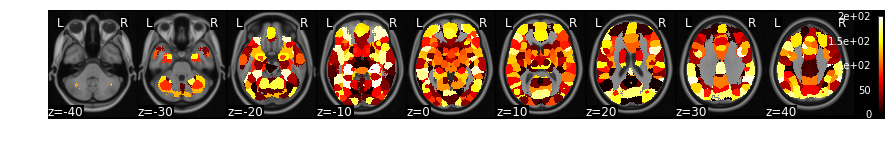

In [6]:
nparcel = 200
roi = Brain_Data(os.path.join(base_dir,'Data/6.Parcellation/whole_brain_cluster_labels_PCA=100_k=%s.nii.gz' % nparcel))
roi.plot()
roi_x = expand_mask(roi)

## Load ISRSA results

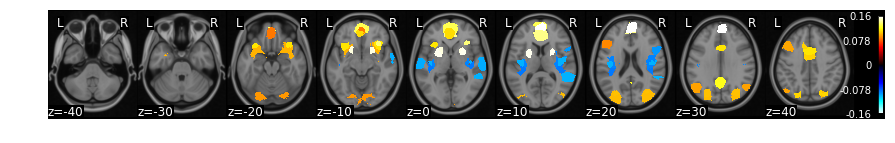

In [7]:
permutation_method = 'vector'
screen = 'Mult'
cond = 'X4'
thresh = 0.05
thresh_type = 'bonf'
ISRSA = Brain_Data(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps',
         'Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s.nii.gz' % (
            nparcel,permutation_method,screen,cond,thresh,thresh_type)))
ISRSA.plot();

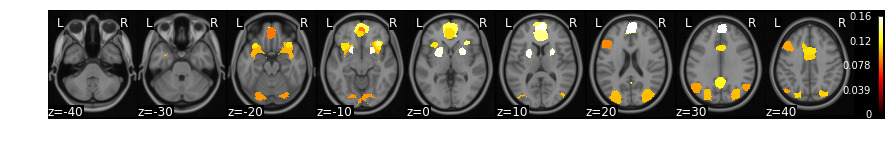

In [8]:
ISRSA_positive = ISRSA.copy()
ISRSA_positive.data[ISRSA_positive.data<0] = 0
ISRSA_positive.plot();

[ 14  25  54  58  63  79  87  95  96 104 109 128 132 135 136 140 141 143
 145 146 147 155 158 159 173 183 191]
27


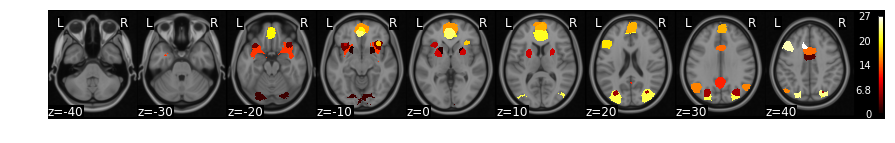

In [9]:
parcels = np.unique(roi.data[ISRSA_positive.data>0])-1 # The data in roi are 1-indexed since 0 represents air
print parcels
print len(parcels)
collapse_mask(roi_x[parcels]).plot();

## Test cluster pattern generalization across conditions

#### Load beta maps

In [ ]:
x2dat = Brain_Data()
x4dat = Brain_Data()
x6dat = Brain_Data()
for sub in subNums:
    x2dat = x2dat.append(Brain_Data(glob.glob(os.path.join(base_dir,
                                             'Data/5.fMRI-BetaMaps/p%03d_MultX2*.nii'%sub))).mean())
    x4dat = x4dat.append(Brain_Data(glob.glob(os.path.join(base_dir,
                                             'Data/5.fMRI-BetaMaps/p%03d_MultX4*.nii'%sub))).mean())
    x6dat = x6dat.append(Brain_Data(glob.glob(os.path.join(base_dir,
                                             'Data/5.fMRI-BetaMaps/p%03d_MultX6*.nii'%sub))).mean())

In [9]:
print x2dat
print x4dat
print x6dat

nltools.data.brain_data.Brain_Data(data=(57, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
nltools.data.brain_data.Brain_Data(data=(57, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
nltools.data.brain_data.Brain_Data(data=(57, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])


#### Compute pattern similarity of all subjects in x4 to all in x2/x6, in all active parcels (takes a long time)

In [10]:
parcelSel = parcels
simResults_all = pd.DataFrame()
print parcelSel
for parcelInd,parcel in enumerate(parcelSel):
    print 'Parcel %i'%parcel,
#     sigClusters = np.unique(x4sig.loc[(x4sig['parcel']==parcel) & (x4sig['p']<0.05),'label'])
    for clust in ['GA','IA','MO','GR']:
        print 'cluster %s'%clust,
        clustNums = np.array(fittedParams.loc[fittedParams['ClustName']==clust,'sub'])
        for sub in clustNums:
            subIndex = list(subNums).index(sub)
#             print sub,
            x4subParcelDat = x4dat[subIndex].apply_mask(roi_x[parcel])
            for cond in ['x2','x6']:
#                 print cond,
                simResults = fittedParams[['sub','theta','phi','ClustName']].copy()
                simResults['condition'] = cond
                simResults['parcel'] = parcel
                simResults['x4clust'] = clust
                simResults['x4sub'] = sub
                if cond == 'x2':
                    simResults['similarity'] = (
                        x4subParcelDat.similarity(x2dat.apply_mask(roi_x[parcel]),method='correlation'))
                elif cond == 'x6':
                    simResults['similarity'] = (
                        x4subParcelDat.similarity(x6dat.apply_mask(roi_x[parcel]),method='correlation'))
                simResults_all = simResults_all.append(simResults)
    print ''
simResults_all.to_csv(os.path.join(base_dir,
           'Results/4.fMRI-PatternClustering/Similarity_X4_to_X2-X6.csv'))

[ 14  25  54  58  63  79  87  95 104 109 128 132 135 136 140 141 143 145
 146 147 155 158 159 173 183 191]
Parcel 14 cluster GA cluster IA cluster MO cluster GR 
Parcel 25 cluster GA cluster IA cluster MO cluster GR 
Parcel 54 cluster GA cluster IA cluster MO cluster GR 
Parcel 58 cluster GA cluster IA cluster MO cluster GR 
Parcel 63 cluster GA cluster IA cluster MO cluster GR 
Parcel 79 cluster GA cluster IA cluster MO cluster GR 
Parcel 87 cluster GA cluster IA cluster MO cluster GR 
Parcel 95 cluster GA cluster IA cluster MO cluster GR 
Parcel 104 cluster GA cluster IA cluster MO cluster GR 
Parcel 109 cluster GA cluster IA cluster MO cluster GR 
Parcel 128 cluster GA cluster IA cluster MO cluster GR 
Parcel 132 cluster GA cluster IA cluster MO cluster GR 
Parcel 135 cluster GA cluster IA cluster MO cluster GR 
Parcel 136 cluster GA cluster IA cluster MO cluster GR 
Parcel 140 cluster GA cluster IA cluster MO cluster GR 
Parcel 141 cluster GA cluster IA cluster MO cluster GR 
Parce

In [11]:
simResults_all.head()

,sub,theta,phi,ClustName,condition,parcel,x4clust,x4sub,similarity
0,124,0.340718,0.055082,GR,x2,14,GA,142,-0.101983
1,126,0.078473,0.000799,MO,x2,14,GA,142,0.160265
2,128,0.030199,0.059205,IA,x2,14,GA,142,-0.000280
3,129,0.206195,-0.095803,MO,x2,14,GA,142,0.589306
4,130,0.078536,-0.017041,MO,x2,14,GA,142,0.620723


#### Load from disk

In [10]:
simResults_all = pd.read_csv(os.path.join(base_dir,
           'Results/4.fMRI-PatternClustering/Similarity_X4_to_X2-X6.csv'),index_col=0)

#### Compare within-group to between-group pattern similarity

In [13]:
# Similarity of sub GA[1]-x4 to sub GA[~1]-x2 vs sub ~GA-x2 etc
stats_all = pd.DataFrame()
for parcel in parcels:# 183 # Loop over unique parcels in x4sig or simResults
    print parcel,
#     sigClusters = np.unique(x4sig.loc[(x4sig['parcel']==parcel) & (x4sig['p']<0.05),'label'])
    for clust in ['GA','IA','MO','GR']:#'IA' # Loop over sigClusters
        clustNums = np.array(fittedParams.loc[fittedParams['ClustName']==clust,'sub'])
        for cond in ['x2','x6']: # Loop over x2 x6
            # Open arrays
            withinSim = pd.DataFrame()
            betweenSim = pd.DataFrame()
            for sub in clustNums:
                withinSim = withinSim.append(simResults_all.loc[(simResults_all['parcel']==parcel) &
                                                                (simResults_all['condition'] == cond) &
                                                                (simResults_all['x4sub']==sub) &
                                                                (simResults_all['sub']!=sub) &
                                                                (simResults_all['ClustName']==clust),'similarity'].reset_index(drop=True))
                betweenSim = betweenSim.append(simResults_all.loc[(simResults_all['parcel']==parcel) &
                                                                  (simResults_all['condition'] == cond) &
                                                                  (simResults_all['x4sub']==sub) &
                                                                  (simResults_all['ClustName']!=clust),'similarity'].reset_index(drop=True))
            stats = pd.DataFrame([two_sample_permutation(withinSim.values.flatten(),betweenSim.values.flatten(),
                                                         tail=1,n_permute=5000)])
            stats['clust'] = clust
            stats['parcel'] = parcel
            stats['condition'] = cond
            stats_all = stats_all.append(stats)
stats_all.to_csv(os.path.join(base_dir,
     'Results/4.fMRI-PatternClustering/PatternGeneralizationStats.csv'))

14 25 54 58 63 79 87 95 104 109 128 132 135 136 140 141 143 145 146 147 155 158 159 173 183 191


## Create brain maps (simple and conjunction)

In [11]:
stats_all = pd.read_csv(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternGeneralizationStats.csv'),index_col=0)

In [10]:
stats_all.head()

,mean,p,clust,parcel,condition
0,-0.013298,0.4030,GA,14,x2
0,-0.084502,0.1320,GA,14,x6
0,-0.014720,0.1942,IA,14,x2
0,-0.006075,0.3552,IA,14,x6
0,0.022129,0.1084,MO,14,x2


In [11]:
means = stats_all.groupby(['clust','parcel','condition'])['mean'].aggregate('mean').unstack().reset_index()
pvals = stats_all.groupby(['clust','parcel','condition'])['p'].aggregate('mean').unstack().reset_index()
stats_all_wide = means.merge(pvals,on=['clust','parcel'],suffixes=['_mean','_p']).reset_index(drop=True)
stats_all_wide

condition,clust,parcel,x2_mean,x6_mean,x2_p,x6_p
0,GA,14,-0.013298,-0.084502,0.4030,0.1320
1,GA,25,-0.102444,-0.079690,0.0178,0.0464
2,GA,54,-0.126861,-0.061515,0.0392,0.1710
3,GA,58,0.161420,0.145234,0.0042,0.0132
4,GA,63,0.076151,0.009974,0.1104,0.4410
5,GA,79,-0.008768,-0.001650,0.4358,0.4858
6,GA,87,-0.023985,0.002488,0.3818,0.4948
7,GA,95,0.147712,0.102868,0.0040,0.0292
8,GA,104,0.118091,0.082566,0.0424,0.1050
9,GA,109,-0.023227,0.036136,0.3636,0.2914


In [17]:
# Double-check if parcels selected above == parcels retrieved from disk
print np.unique(stats_all_wide.parcel)
print parcels

[ 14  25  54  58  63  79  87  95 104 109 128 132 135 136 140 141 143 145
 146 147 155 158 159 173 183 191]
[ 14  25  54  58  63  79  87  95 104 109 128 132 135 136 140 141 143 145
 146 147 155 158 159 173 183 191]


#### Effect in x2 OR x6

Int64Index([3, 7, 8, 10, 14, 17, 21, 23], dtype='int64') [ 58  95 104 128 140 145 158 173] [[0.1614197 ]
 [0.14771199]
 [0.11809135]
 [0.13411873]
 [0.24844502]
 [0.13465287]
 [0.15322414]
 [0.19977587]]


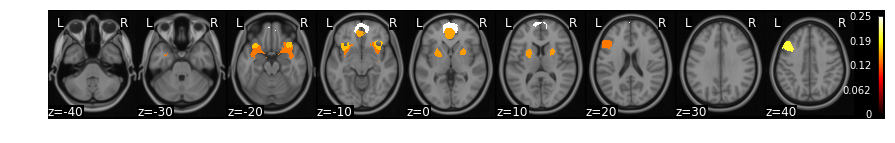

Int64Index([3, 7, 10, 12, 14, 15, 21, 23], dtype='int64') [ 58  95 128 135 140 141 158 173] [[0.1452343 ]
 [0.10286781]
 [0.14864578]
 [0.13716342]
 [0.26707215]
 [0.12911586]
 [0.15084171]
 [0.22744062]]


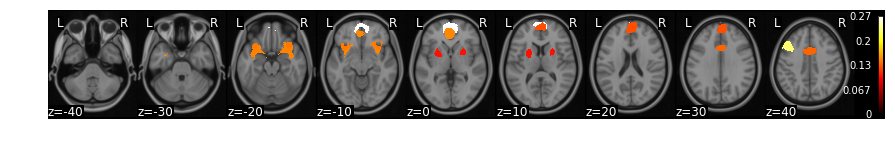

Int64Index([54, 55, 56, 57, 58, 60, 64, 66, 67, 70, 71, 72, 73, 76, 77], dtype='int64') [ 54  58  63  79  87 104 135 140 141 146 147 155 158 183 191] [[0.11773184]
 [0.05621462]
 [0.12078356]
 [0.08283486]
 [0.05305155]
 [0.07879042]
 [0.11116751]
 [0.05700401]
 [0.04742339]
 [0.05003357]
 [0.05201533]
 [0.10039125]
 [0.05358831]
 [0.08003778]
 [0.04294902]]


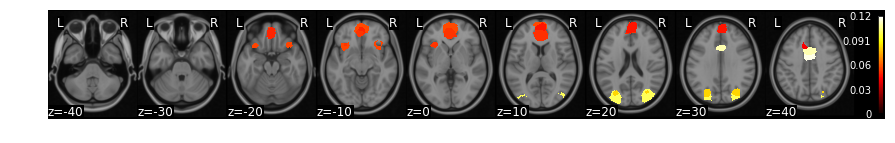

Int64Index([54, 55, 56, 57, 58, 60, 64, 65, 66, 67, 70, 71, 72, 73, 76, 77], dtype='int64') [ 54  58  63  79  87 104 135 136 140 141 146 147 155 158 183 191] [[0.07208035]
 [0.03912623]
 [0.10423215]
 [0.07389068]
 [0.05697644]
 [0.04969882]
 [0.08228706]
 [0.03568093]
 [0.06677444]
 [0.04969104]
 [0.0404807 ]
 [0.07293663]
 [0.09483337]
 [0.06791325]
 [0.07447915]
 [0.04041797]]


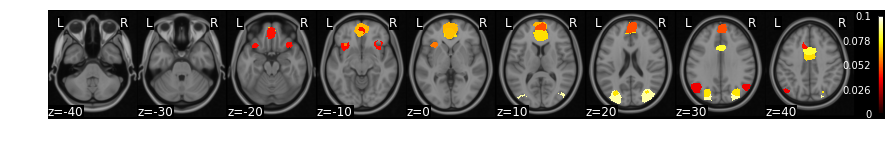

Int64Index([89, 100, 103], dtype='int64') [132 159 191] [[0.05990268]
 [0.06120053]
 [0.0673356 ]]


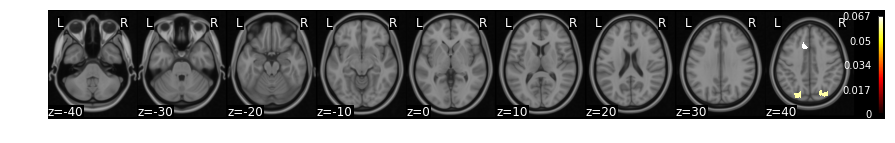

Int64Index([89, 100, 103], dtype='int64') [132 159 191] [[0.0899136 ]
 [0.06964005]
 [0.05501418]]


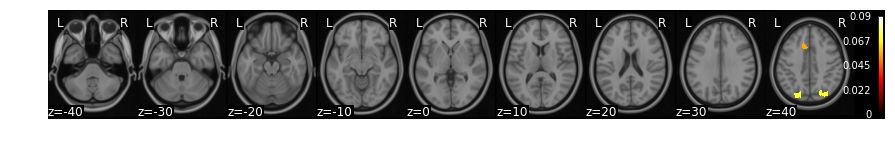

In [18]:
for clust in ['GA','IA','MO']:
    for cond in ['x2','x6']:
        active = stats_all_wide.loc[(stats_all_wide['clust']==clust) &
                                    (stats_all_wide['%s_p'%cond]<0.05) &
                                    (stats_all_wide['%s_mean'%cond]>0)].index
        parcels = np.array(stats_all_wide.loc[active,'parcel'])
        means = np.array(stats_all_wide.loc[active,['%s_mean'%cond]])
        print active, parcels, means
        active_map = collapse_mask(roi_x[parcels],auto_label=True)
        active_map_means = roi.copy()
        active_map_means.data[:] = float(0)
        for i,parcel in enumerate(parcels):
            active_map_means.data[roi_x[parcel].data>0] = means[i]*100000
        active_map_means.data = active_map_means.data.astype(float)/100000
        active_map_means.plot()
        
        plt.savefig(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternGeneralization_%s_x4-to-%s_meanDiffs.png' % (
                clust,cond)))
        plt.show()
        active_map_means.write(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternGeneralization_%s_x4-to-%s_meanDiffs.nii.gz' % (
                clust,cond)))

#### Conjunction of x2 AND x6

Int64Index([54, 55, 56, 57, 58, 60, 64, 66, 67, 70, 71, 72, 73, 76, 77], dtype='int64') [ 54  58  63  79  87 104 135 140 141 146 147 155 158 183 191] [0.09490609 0.04767042 0.11250786 0.07836277 0.05501399 0.06424462
 0.09672729 0.06188923 0.04855721 0.04525714 0.06247598 0.09761231
 0.06075078 0.07725847 0.0416835 ]


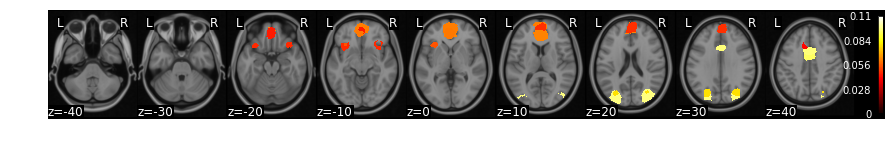

Int64Index([3, 7, 10, 14, 21, 23], dtype='int64') [ 58  95 128 140 158 173] [0.153327   0.1252899  0.14138226 0.25775859 0.15203293 0.21360825]


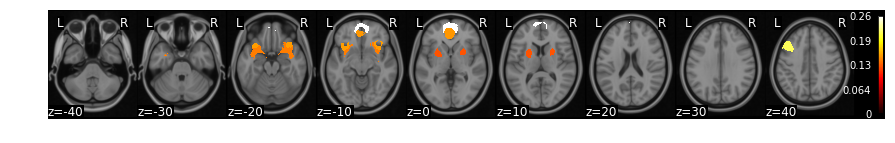

Int64Index([89, 100, 103], dtype='int64') [132 159 191] [0.07490814 0.06542029 0.06117489]


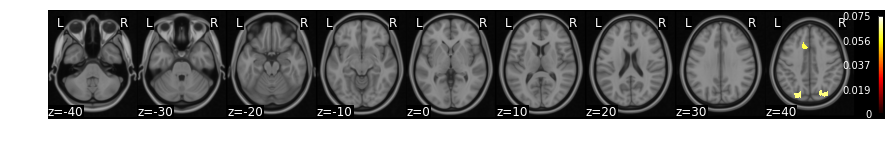

In [19]:
for clust in ['IA','GA','MO']:
    active = stats_all_wide.loc[(stats_all_wide['clust']==clust) &
                                (stats_all_wide['x2_p']<0.05) &
                                (stats_all_wide['x6_p']<0.05) &
                                (stats_all_wide['x2_mean']>0) &
                                (stats_all_wide['x6_mean']>0)].index
    parcels = np.array(stats_all_wide.loc[active,'parcel'])
    means = np.array(np.mean(stats_all_wide.loc[active,['x2_mean','x6_mean']],axis=1))
    print active, parcels, means
    active_map = collapse_mask(roi_x[parcels],auto_label=True)
    active_map_means = roi.copy()
    active_map_means.data[:] = float(0)
    for i,parcel in enumerate(parcels):
        active_map_means.data[roi_x[parcel].data>0] = means[i]*100000
    active_map_means.data = active_map_means.data.astype(float)/100000
    active_map_means.plot()
    plt.savefig(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternGeneralization_%s_x4-to-x2x6_meanDiffs.png' % (
                clust)))
    plt.show()
    active_map_means.write(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternGeneralization_%s_x4-to-x2x6_meanDiffs.nii.gz' % (
                clust)))

In [13]:
# Pretty plot?
from nilearn.plotting import plot_stat_map;

/home/decision/jervbaa/.conda/envs/hmtg_fmri_nc/lib/python2.7/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


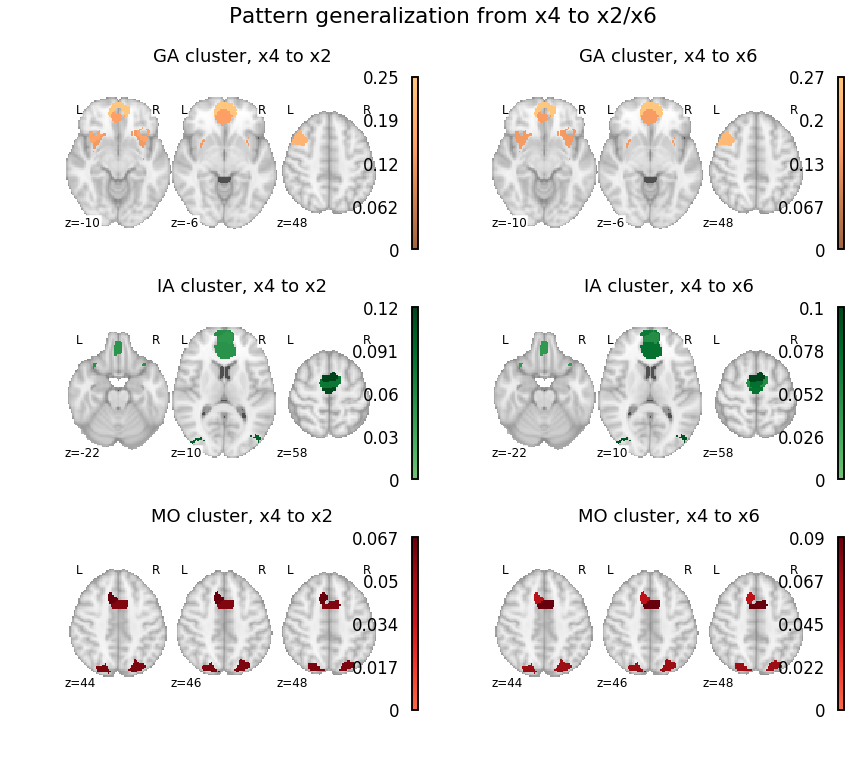

In [21]:
sns.set_context('talk')
fig,ax = plt.subplots(3,2,figsize=[14,12])
colormaps = ['copper','Greens','Reds']
for i,clust in enumerate(['GA','IA','MO']):
    for j,cond in enumerate(['x2','x6']):
        img = os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternGeneralization_%s_x4-to-%s_meanDiffs.nii.gz' % (
                  clust,cond))
        plot_stat_map(img,axes=ax[i,j],draw_cross=False,display_mode='z', cut_coords=3,cmap=colormaps[i])
        ax[i,j].set_title('%s cluster, x4 to %s'%(clust,cond))
plt.suptitle('Pattern generalization from x4 to x2/x6',y=0.95)
plt.savefig(os.path.join(base_dir,
 'Results/4.fMRI-PatternClustering/PatternGeneralization_perCond_allClusters_meanDiffs.png'),
           dpi=200)

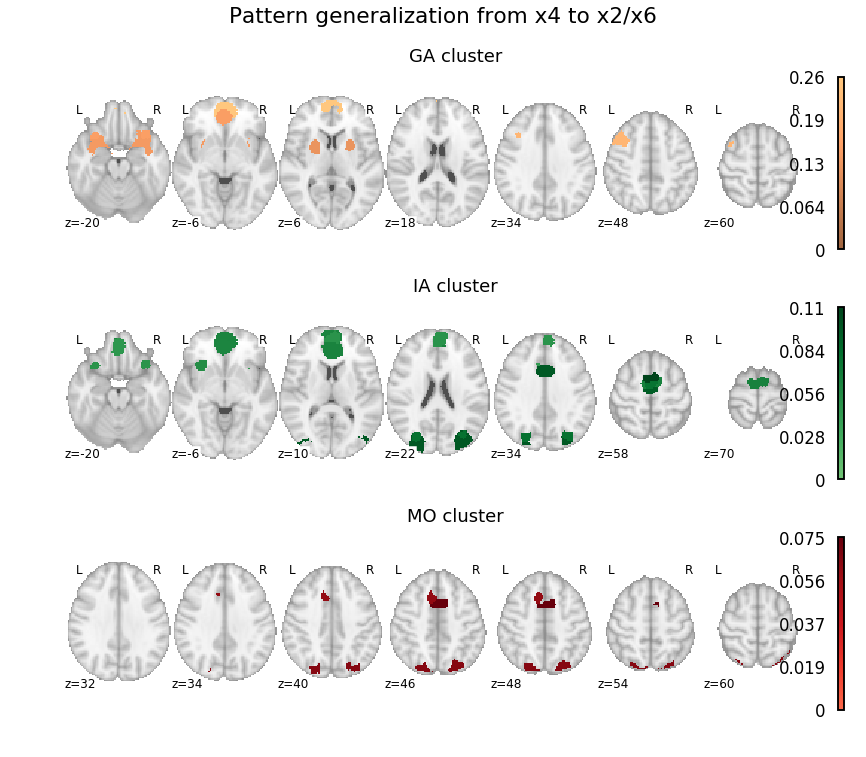

In [22]:
sns.set_context('talk')
fig,ax = plt.subplots(3,1,figsize=[14,12])
colormaps = ['copper','Greens','Reds']
for i,clust in enumerate(['GA','IA','MO']):
    img = os.path.join(base_dir,'Results/4.ClusterBrain',
       'PatternGeneralization_%s_x4-to-x2x6_meanDiffs.nii.gz'%(clust))
    plot_stat_map(img,axes=ax[i],draw_cross=False,display_mode='z', cut_coords=7,cmap=colormaps[i])
    ax[i].set_title('%s cluster'%clust)
plt.suptitle('Pattern generalization from x4 to x2/x6',y=0.95)
plt.savefig(os.path.join(base_dir,
 'Results/4.fMRI-PatternClustering/PatternGeneralization_allClusters_x4-to-x2x6_meanDiffs.png'),
           dpi=200)

##### Generate figure 4C-D-E

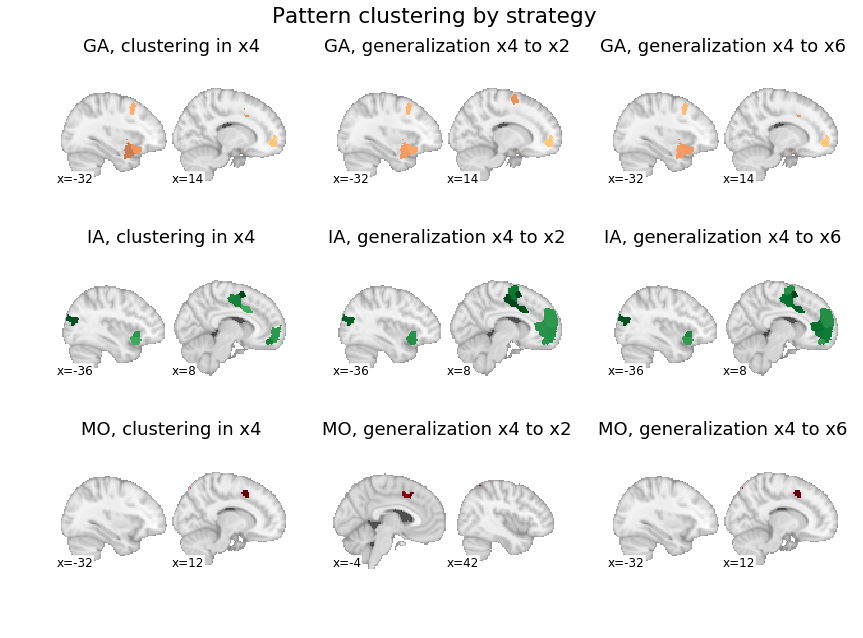

In [23]:
import matplotlib;
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')
fig,ax = plt.subplots(3,3,figsize=[14,10])
n_slices = 2
display_mode = 'x'
cbar_choice = False
colormaps = ['copper','Greens','Reds']
for i,clust in enumerate(['GA','IA','MO']):
    img = os.path.join(base_dir,'Results/4.ClusterBrain',
           'PatternClustering_X4_%s_meanDiffs.nii.gz'%(clust))
    plot_stat_map(img,axes=ax[i,0],draw_cross=False,display_mode=display_mode,
                  cut_coords=n_slices,cmap=colormaps[i],colorbar=cbar_choice)
    ax[i,0].set_title('%s, clustering in x4'%(clust))
    for j,cond in enumerate(['x2','x6']):
        img = os.path.join(base_dir,
                 'Results/4.fMRI-PatternClustering/PatternGeneralization_%s_x4-to-%s_meanDiffs.nii.gz' % (
                    clust,cond))
        plot_stat_map(img,axes=ax[i,1+j],draw_cross=False,display_mode=display_mode,
                      cut_coords=n_slices,cmap=colormaps[i],colorbar=cbar_choice)
        ax[i,1+j].set_title('%s, generalization x4 to %s'%(clust,cond))
plt.suptitle('Pattern clustering by strategy',y=0.95)

plt.savefig(os.path.join(base_dir,
 'Results/4.fMRI-PatternClustering/PatternClusteringAndGeneralization_allClusters_meanDiffs.pdf'),
           transparent=True)

#### Conjunction of clustering within x4 condition AND generalization to x2 AND x6

[ 54  58  63  79  87  95 128 132 135 140 146 155 158 159 173 183 191]
IA [ 54  58  63  79  87 135 140 146 155 183]


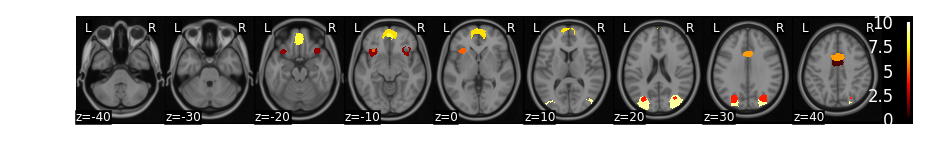

GA [ 58  95 128 140 158 173]


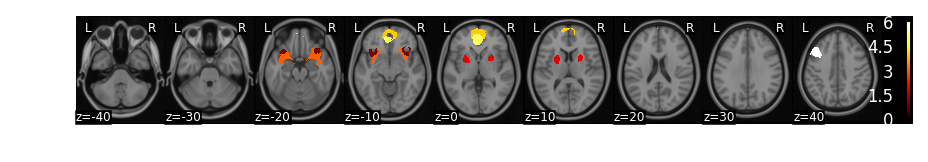

MO [132 159 191]


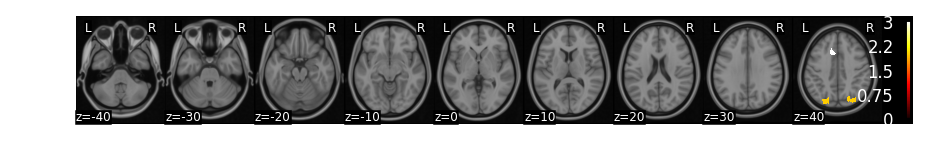

In [24]:
groupExclude = 'GR'
stats_x4 = pd.read_csv(os.path.join(base_dir,
    'Results/4.fMRI-PatternClustering',
    'SilhouetteScores_X4_exclude-%s.csv'%(
        groupExclude)),index_col=0)
stats_x4 = stats_x4.loc[stats_x4['cond']=='X4',['label','parcel','mean','p']]
stats_x4.columns = ['clust','parcel','x4_mean','x4_p']
# print stats_x4.head()
stats_x2x6 = pd.read_csv(os.path.join(base_dir,
     'Results/4.fMRI-PatternClustering/PatternGeneralizationStats.csv'),
       index_col=0)
means = stats_x2x6.groupby(['clust','parcel','condition'])['mean'].aggregate('mean').unstack().reset_index()
pvals = stats_x2x6.groupby(['clust','parcel','condition'])['p'].aggregate('mean').unstack().reset_index()
stats_x2x6_wide = means.merge(pvals,on=['clust','parcel'],suffixes=['_mean','_p']).reset_index(drop=True)
stats_all = stats_x4.merge(stats_x2x6_wide,on=['clust','parcel'])
stats_all.head()
stats_conj = stats_all.loc[(stats_all['x4_p']<0.05) & (stats_all['x2_p'] < 0.05) & (stats_all['x6_p']<0.05)]
parcels = np.unique(stats_conj['parcel'])
print parcels

for clust in ['IA','GA','MO']:
    active = stats_conj.loc[(stats_conj['clust']==clust)].index
    parcels = np.array(stats_conj.loc[active,'parcel'])
    print clust, parcels
    active_map = collapse_mask(roi_x[parcels],auto_label=True)
    active_map.data = active_map.data.astype(float)
    active_map.plot()
    plt.savefig(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternConjunction_%s.png'%clust))
    plt.show()
    active_map.write(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternConjunction_%s.nii.gz'%clust))
    active_map.threshold(upper=0.0001,binarize=True).write(os.path.join(base_dir,
             'Results/4.fMRI-PatternClustering/PatternConjunction_%s_binary.nii.gz'%clust))

In [25]:
stats_conj.to_csv(os.path.join(base_dir,
           'Results/4.fMRI-PatternClustering/PatternConjunctionStats.csv'))